#####  🧑 Authored By - Harsh (hpnightowl) 

In [64]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Overview

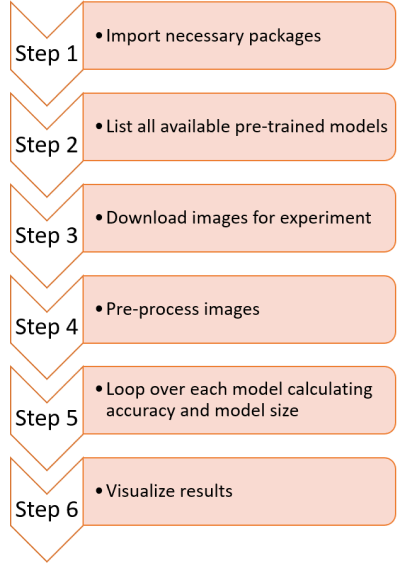

## Importing Libraries

In [65]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping,TensorBoard
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


## Fetching Giving data from Google Drive and checking all folders with path

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
os.listdir('drive/MyDrive/loopr_vit_dse_assignment_data')

['Rook-resize',
 'bishop_resized',
 'knight-resize',
 'Queen-Resized',
 'pawn_resized']

# Loading DataSet

In [68]:
path = 'drive/MyDrive/loopr_vit_dse_assignment_data'
path_img = list(glob.glob(path+'/**/*.jpg'))

In [69]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_img))
file_path = pd.Series(path_img, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
imgs_data = pd.concat([file_path, labels], axis=1)
imgs_data = imgs_data.sample(frac=1).reset_index(drop=True)
imgs_data.head()

,File_Path,Labels
0,drive/MyDrive/loopr_vit_dse_assignment_data/bi...,bishop_resized
1,drive/MyDrive/loopr_vit_dse_assignment_data/kn...,knight-resize
2,drive/MyDrive/loopr_vit_dse_assignment_data/Ro...,Rook-resize
3,drive/MyDrive/loopr_vit_dse_assignment_data/Qu...,Queen-Resized
4,drive/MyDrive/loopr_vit_dse_assignment_data/bi...,bishop_resized


# EDA

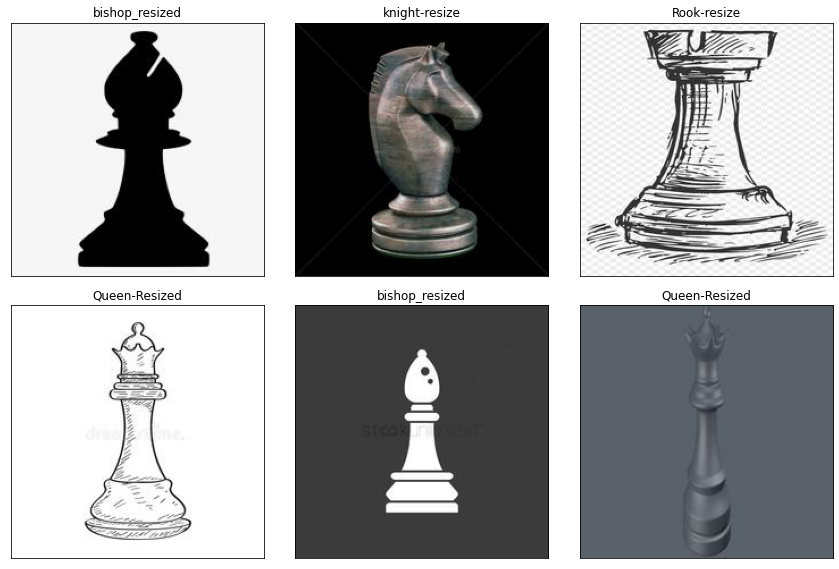

In [70]:
# Randomly checking out data set batch
def check_imgs():
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                          subplot_kw={'xticks': [], 'yticks': []})
  for i, ax in enumerate(axes.flat):
      ax.imshow(plt.imread(imgs_data.File_Path[i]))
      ax.set_title(imgs_data.Labels[i])
  plt.tight_layout()
  plt.show()

check_imgs()

knight-resize     174
bishop_resized    141
Rook-resize       139
Queen-Resized     115
pawn_resized       82
Name: Labels, dtype: int64


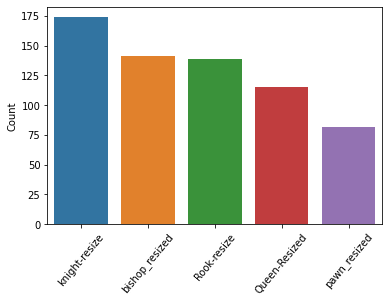

In [71]:
# function displays and plots the data distribution of different categories 
def data_histogram():    
  counts = imgs_data.Labels.value_counts()
  print(counts)
  sns.barplot(x=counts.index, y=counts)
  plt.ylabel('Count')
  plt.xticks(rotation=50);

data_histogram()

- dataset has variable number of images of single categories it will be little biased toward the knight-resize

# Splitting data Set and modulation of functions

In [72]:
# Splitting the data in Testing and Training 
train_data, test_data = train_test_split(imgs_data, test_size=0.25, random_state=1)

 - Splitting the data 3 : 1 data distribution criteria 

In [73]:
# function for data validation and data training data 
def train_preprocess(pre,type,size):
  type_datagen = ImageDataGenerator(preprocessing_function=pre,
                                     validation_split=0.2)
  type_gen = type_datagen.flow_from_dataframe(
         dataframe=train_data,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset=type,
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
  return type_gen

In [74]:
# fnction for data testing pre processing 
def test_preprocess(pre,size):
  test_datagen = ImageDataGenerator(preprocessing_function=pre)
  test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
  return test_gen
    

In [75]:
# Onehut for models computation
def model_fun(pre,name_model,size):
    
    train_gen = train_preprocess(pre,'training',size)
    valid_gen =  train_preprocess(pre,'validation',size)
    test_gen = test_preprocess(pre,size)

    pre_model = name_model(input_shape=(size,size, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    #my_callbacks  = [TensorBoard(log_dir="./logs")]

    rlronp=tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5,   patience=1,  verbose=1)
    estop=tf.keras.callbacks.EarlyStopping( monitor="val_loss",   patience=4,  verbose=1,   restore_best_weights=True)
    train_thold=.98
    valid_thold=.92
    my_callbacks=[rlronp, estop] 

    history = model.fit(train_gen,validation_data=valid_gen,
                        epochs=100,callbacks=my_callbacks,verbose=0);
    print('\033[01m              Plotting Accuracy, val_accuracy, loss, val_loss \033[0m')
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
    plt.show()
    
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    print('\033[01m              Classification_report \033[0m')
    # Classification report
    cm=confusion_matrix(test_data.Labels,pred)
    clr = classification_report(test_data.Labels, pred)
    print(clr)
    print('\033[01m Display 6 pictures of the dataset with their labels \033[0m')
    # Display 6 pictures of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_data.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_data.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
    
    print('\033[01m              Results \033[0m')
    # Results
    results = model.evaluate(test_gen, verbose=0)
    print("    Test Loss:\033[31m \033[01m {:.5f} \033[30m \033[0m".format(results[0]))
    print("Test Accuracy:\033[32m \033[01m {:.2f}% \033[30m \033[0m".format(results[1] * 100))
    
    ## save the models 
    working_dir=r'./'
    save_path=os.path.join(working_dir, str(name_model) + '.h5')
    model.save(save_path, overwrite=True, include_optimizer=True, save_format='h5')
    
    return results

# Modeling 

## Model - 1 (InceptionV3)

Found 391 validated image filenames belonging to 5 classes.
Found 97 validated image filenames belonging to 5 classes.
Found 163 validated image filenames belonging to 5 classes.

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 7: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 3.
Epoch 7: early stopping
              Plotting Accuracy, val_accuracy, loss, val_loss 


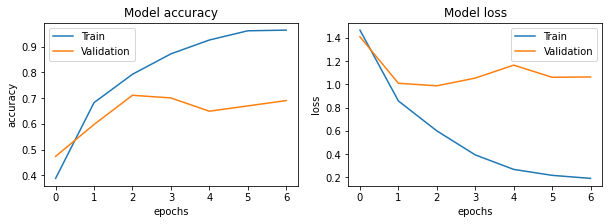

6/6 [==============================] - 2s 65ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.47      0.52      0.49        27
   Rook-resize       0.73      0.72      0.73        46
bishop_resized       0.54      0.47      0.51        40
 knight-resize       0.82      0.94      0.88        34
  pawn_resized       0.50      0.44      0.47        16

      accuracy                           0.64       163
     macro avg       0.61      0.62      0.61       163
  weighted avg       0.64      0.64      0.64       163

 Display 6 pictures of the dataset with their labels 


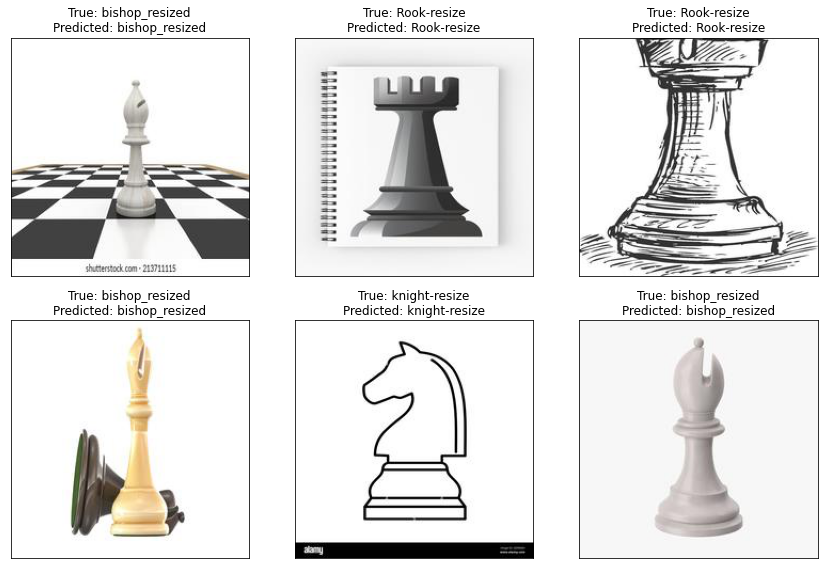

              Results 
    Test Loss:  0.98096  
Test Accuracy:  64.42%  


In [76]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
result_InceptionV3 = model_fun(preprocess_input,InceptionV3,100)

## Model - 2 (MobileNetV2)

Found 391 validated image filenames belonging to 5 classes.
Found 97 validated image filenames belonging to 5 classes.
Found 163 validated image filenames belonging to 5 classes.

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 7: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 8: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 4.
Epoch 8: early stopping
              Plotting Accuracy, val_accuracy, loss, val_loss 


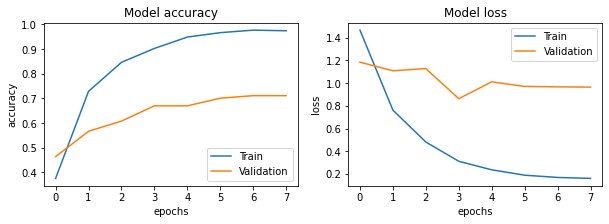

6/6 [==============================] - 1s 62ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.52      0.41      0.46        27
   Rook-resize       0.89      0.74      0.81        46
bishop_resized       0.49      0.65      0.56        40
 knight-resize       0.78      0.91      0.84        34
  pawn_resized       0.82      0.56      0.67        16

      accuracy                           0.68       163
     macro avg       0.70      0.65      0.67       163
  weighted avg       0.70      0.68      0.68       163

 Display 6 pictures of the dataset with their labels 


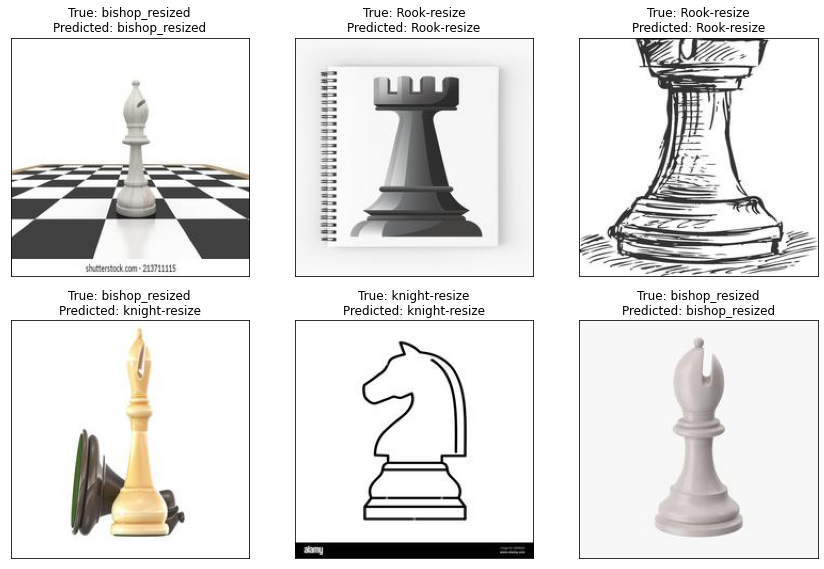

              Results 
    Test Loss:  0.89823  
Test Accuracy:  68.10%  


In [77]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
result_MobileNetV2 = model_fun(preprocess_input,MobileNetV2,100)

## Model - 3 ( VGG 19 )

Found 391 validated image filenames belonging to 5 classes.
Found 97 validated image filenames belonging to 5 classes.
Found 163 validated image filenames belonging to 5 classes.

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 8: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Restoring model weights from the end of the best epoch: 6.
Epoch 10: early stopping
              Plotting Accuracy, val_accuracy, loss, val_loss 


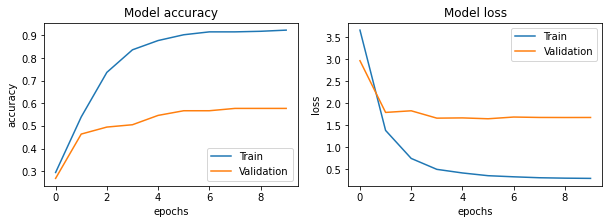

6/6 [==============================] - 1s 69ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.46      0.48      0.47        27
   Rook-resize       0.74      0.54      0.62        46
bishop_resized       0.51      0.53      0.52        40
 knight-resize       0.78      0.91      0.84        34
  pawn_resized       0.35      0.44      0.39        16

      accuracy                           0.60       163
     macro avg       0.57      0.58      0.57       163
  weighted avg       0.61      0.60      0.59       163

 Display 6 pictures of the dataset with their labels 


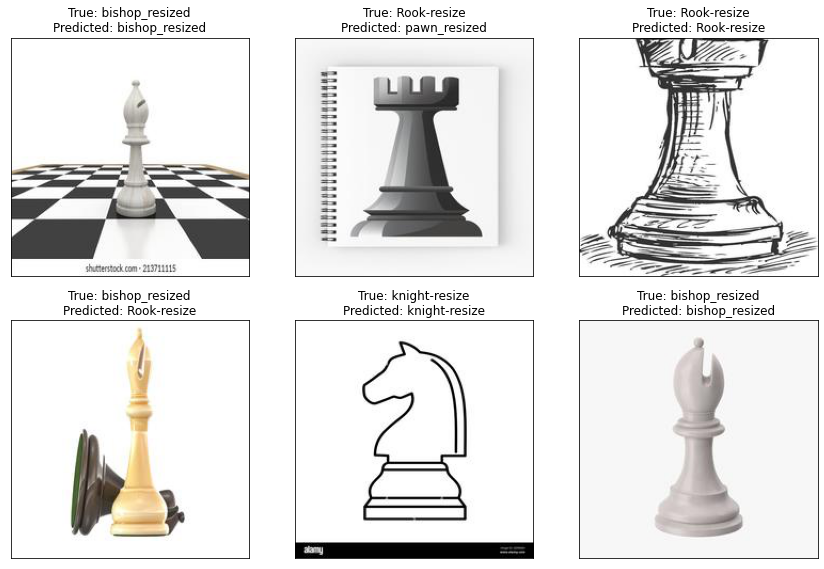

              Results 
    Test Loss:  1.30911  
Test Accuracy:  59.51%  


In [78]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

result_Vgg19 = model_fun(preprocess_input,VGG19,100)

## Model - 4 (InceptionResNetV2)

Found 391 validated image filenames belonging to 5 classes.
Found 97 validated image filenames belonging to 5 classes.
Found 163 validated image filenames belonging to 5 classes.

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 15: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 16: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 17: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 18: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Restoring model weights from the end of the best epoch: 14.
Epoch 18: early stopping
              Plotting Accuracy, val_accuracy, loss, val_loss 


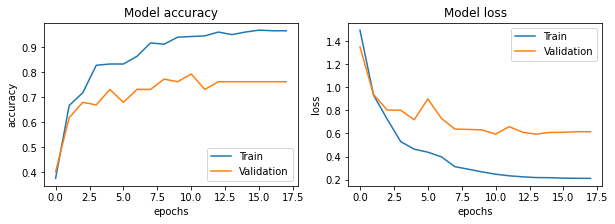

6/6 [==============================] - 4s 177ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.71      0.56      0.63        27
   Rook-resize       0.88      0.91      0.89        46
bishop_resized       0.74      0.80      0.77        40
 knight-resize       0.86      0.91      0.89        34
  pawn_resized       0.73      0.69      0.71        16

      accuracy                           0.80       163
     macro avg       0.79      0.77      0.78       163
  weighted avg       0.80      0.80      0.80       163

 Display 6 pictures of the dataset with their labels 


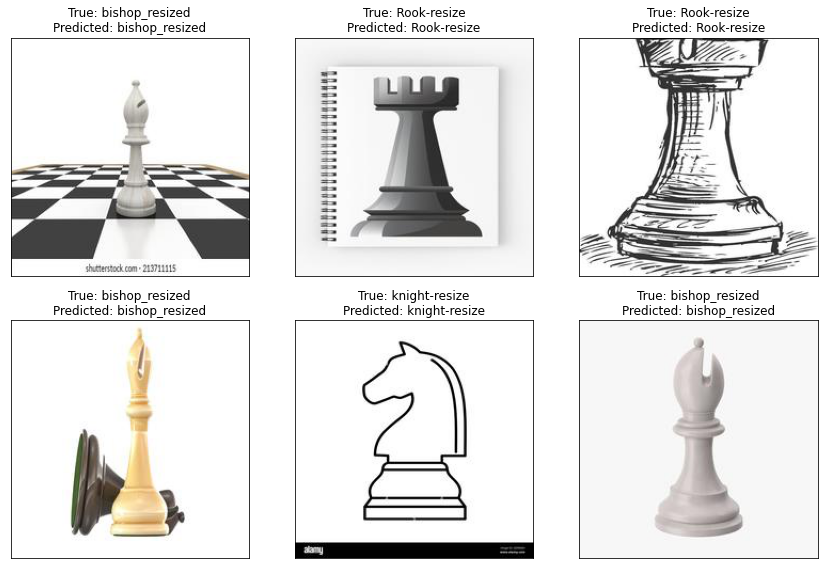

              Results 
    Test Loss:  0.59121  
Test Accuracy:  80.37%  


In [79]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
result_InceptionResNetV2 = model_fun(preprocess_input,InceptionResNetV2,224)

## Model - 5 ( DenseNet201 )


Found 391 validated image filenames belonging to 5 classes.
Found 97 validated image filenames belonging to 5 classes.
Found 163 validated image filenames belonging to 5 classes.

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 10: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 11: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 7.
Epoch 11: early stopping
              Plotting Accuracy, val_accuracy, loss, val_loss 


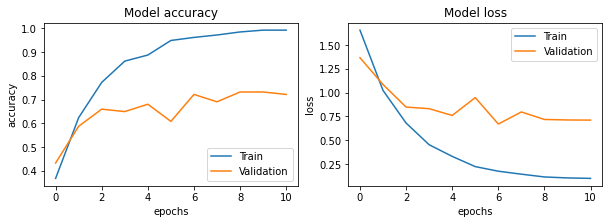

6/6 [==============================] - 3s 71ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.60      0.56      0.58        27
   Rook-resize       0.95      0.78      0.86        46
bishop_resized       0.63      0.78      0.70        40
 knight-resize       0.79      1.00      0.88        34
  pawn_resized       0.75      0.38      0.50        16

      accuracy                           0.75       163
     macro avg       0.74      0.70      0.70       163
  weighted avg       0.76      0.75      0.74       163

 Display 6 pictures of the dataset with their labels 


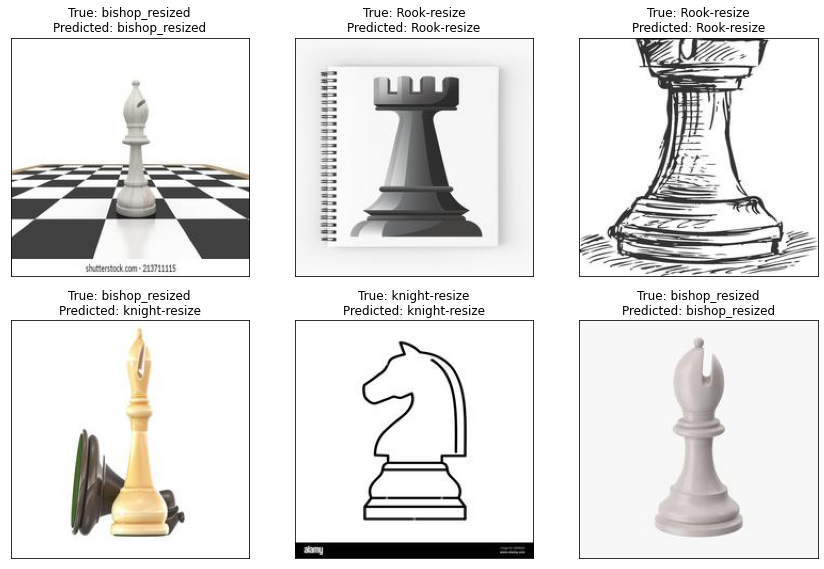

              Results 
    Test Loss:  0.76417  
Test Accuracy:  74.85%  


In [80]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
result_DenseNet201 = model_fun(preprocess_input,DenseNet201,100)

## Model - 6 (Xception)

Found 391 validated image filenames belonging to 5 classes.
Found 97 validated image filenames belonging to 5 classes.
Found 163 validated image filenames belonging to 5 classes.

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 8: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 4.
Epoch 8: early stopping
              Plotting Accuracy, val_accuracy, loss, val_loss 


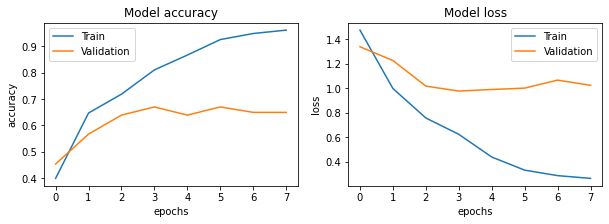

6/6 [==============================] - 1s 69ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.48      0.37      0.42        27
   Rook-resize       0.87      0.59      0.70        46
bishop_resized       0.44      0.68      0.53        40
 knight-resize       0.82      0.91      0.86        34
  pawn_resized       0.33      0.25      0.29        16

      accuracy                           0.61       163
     macro avg       0.59      0.56      0.56       163
  weighted avg       0.64      0.61      0.61       163

 Display 6 pictures of the dataset with their labels 


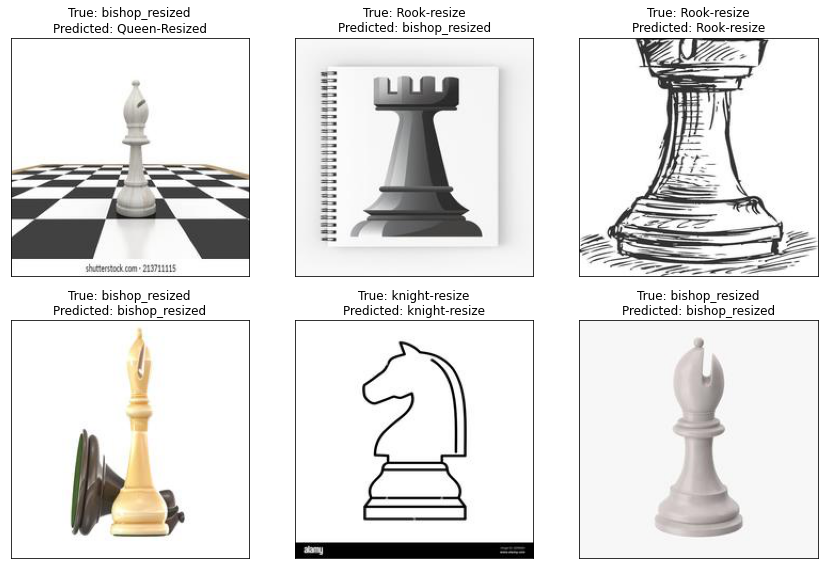

              Results 
    Test Loss:  1.03968  
Test Accuracy:  60.74%  


In [81]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

result_Xception = model_fun(preprocess_input,Xception,100)

# 📰 Comparing Models ( Final Report )

In [82]:
output = pd.DataFrame({'Model':['InceptionV3','InceptionResNetV2',
                                'DenseNet201','MobileNetV2 ','Vgg16','Xception'],
                      'Accuracy':[result_InceptionV3[1], result_InceptionResNetV2[1],
                                  result_DenseNet201[1], result_MobileNetV2[1],result_Vgg19[1], result_Xception[1]]})
print(output)

               Model  Accuracy
0        InceptionV3  0.644172
1  InceptionResNetV2  0.803681
2        DenseNet201  0.748466
3       MobileNetV2   0.680982
4              Vgg16  0.595092
5           Xception  0.607362


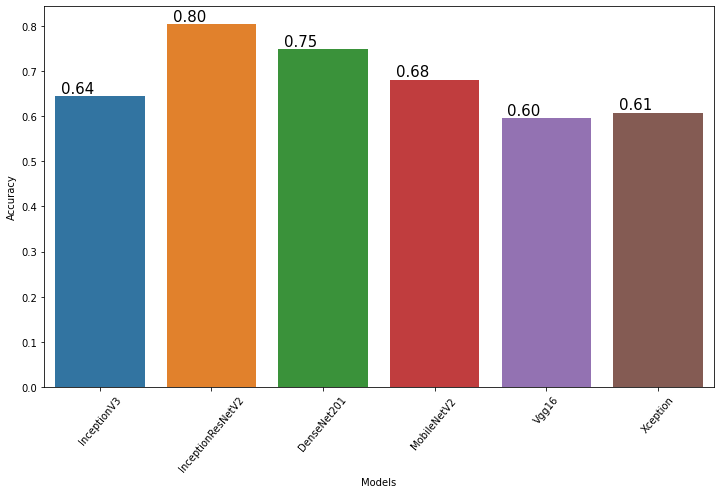

In [83]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 4,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=50);

# Saving the Best model 
 - All models are saved in already in the above split and modulation section can check the your storage 

# Result 
- Clearly we can see ✅**InceptionResNetV2** is the winner among the 6 Models and DenseNet201 is the 2nd Runnerup 

# Future Improvements

- After Finding the best model we can tweak the HyperParameters

# Trials
 - I tried data Argumentation but later i found that the all models accuracy was decreasing so will do it one by one

# References
- https://www.tensorflow.org/api_docs/python/tf/keras/applications
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks